In [34]:
with open("molvufile.txt", "r") as file:
    content = file.read()
print(content)

GO VIAJE NEGRO:
Mochila ideal para viajes y uso diario, apta para la cabina del avión, con 23 compartimentos (5 externos + 18 internos).
Características técnicas incluyen espacio especial para laptop de hasta 15.6", semi impermeabilidad, compartimento secreto para el pasaporte, bolsillo para pachón, capa de mesh en la espalda, tirantes ergonómicos y enguatados, y dos compartimentos principales para accesorios de tecnología y ropa.
El compartimento de tecnología cuenta con espacio para laptop, tablet de 10 pulgadas, libretas, bolsillos elásticos multiusos, porta lapiceros, y bolsillo con red y zipper.
El compartimento de viaje ofrece diversos bolsillos con redes elásticas y zipper, amplio espacio para ropa, y compatibilidad con el Organizador Molvu (se vende por separado).
Medidas cumplen con estándar de equipaje de mano.

GO LIGHT NEGRO:
Mochila ligera y minimalista para laptop, semi impermeable, perfecta para uso diario.
Características técnicas incluyen espacio especial para laptop d

In [35]:
def remove_newlines(serie):
    serie = serie.replace('\n', ' ')
    serie = serie.replace('\\n', ' ')
    serie = serie.replace('  ', ' ')
    serie = serie.replace('  ', ' ')
    return serie

remove_newlines(content)

'GO VIAJE NEGRO: Mochila ideal para viajes y uso diario, apta para la cabina del avión, con 23 compartimentos (5 externos + 18 internos). Características técnicas incluyen espacio especial para laptop de hasta 15.6", semi impermeabilidad, compartimento secreto para el pasaporte, bolsillo para pachón, capa de mesh en la espalda, tirantes ergonómicos y enguatados, y dos compartimentos principales para accesorios de tecnología y ropa. El compartimento de tecnología cuenta con espacio para laptop, tablet de 10 pulgadas, libretas, bolsillos elásticos multiusos, porta lapiceros, y bolsillo con red y zipper. El compartimento de viaje ofrece diversos bolsillos con redes elásticas y zipper, amplio espacio para ropa, y compatibilidad con el Organizador Molvu (se vende por separado). Medidas cumplen con estándar de equipaje de mano. GO LIGHT NEGRO: Mochila ligera y minimalista para laptop, semi impermeable, perfecta para uso diario. Características técnicas incluyen espacio especial para laptop d

In [36]:
import pandas as pd

df = pd.DataFrame({'text': [remove_newlines(content)]})
df.to_csv('processed.csv', index=False)
df.head()

,text
0,GO VIAJE NEGRO: Mochila ideal para viajes y us...


<Axes: >

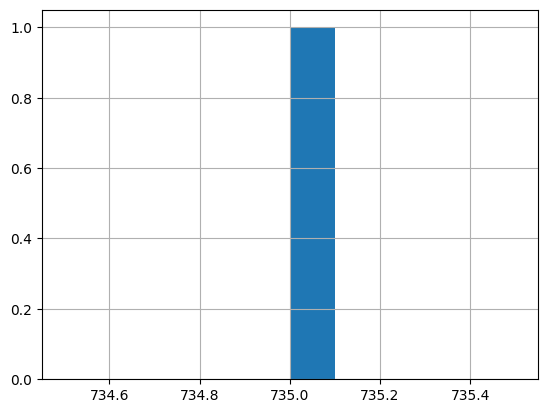

In [37]:
import tiktoken
import matplotlib
tokenizer = tiktoken.get_encoding("cl100k_base")
df = pd.read_csv('processed.csv')
df.columns = ['text']
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [38]:
max_tokens = 150
# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):
    # Split the text into sentences
    sentences = text.split('.\n')
    
    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    chunks = []
    tokens_so_far = 0
    chunk = []
    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):
        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0
        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue
        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1
    return chunks
# shortened = []

# shortened = split_into_many(content)
shortened = []
# print(shortened)
# print(len(shortened))
for row in df.iterrows():
    if row[1]['text'] is None:
        continue
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(content)
    else:
        shortened.append(content)

<Axes: >

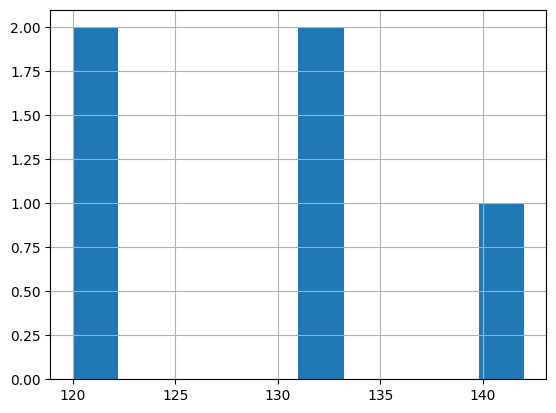

In [39]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [41]:
import numpy as np
from scipy.spatial.distance import cosine

df=pd.read_csv('embedings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)
df.head()



,n_tokens,embeddings
text,,
"GO VIAJE NEGRO:\nMochila ideal para viajes y uso diario, apta para la cabina del avión, con 23 compartimentos (5 externos + 18 internos). Características técnicas incluyen espacio especial para laptop de hasta 15.6"", semi impermeabilidad, compartimento secreto para el pasaporte, bolsillo para pachón, capa de mesh en la espalda, tirantes ergonómicos y enguatados, y dos compartimentos principales para accesorios de tecnología y ropa.",120,"[-0.005336785223335028, -0.007172850426286459,..."
"El compartimento de tecnología cuenta con espacio para laptop, tablet de 10 pulgadas, libretas, bolsillos elásticos multiusos, porta lapiceros, y bolsillo con red y zipper. El compartimento de viaje ofrece diversos bolsillos con redes elásticas y zipper, amplio espacio para ropa, y compatibilidad con el Organizador Molvu (se vende por separado). Medidas cumplen con estándar de equipaje de mano. \nGO LIGHT NEGRO:\nMochila ligera y minimalista para laptop, semi impermeable, perfecta para uso diario.",131,"[-0.012381264008581638, -0.0051605431362986565..."
"Características técnicas incluyen espacio especial para laptop de hasta 15.6"", tirantes ergonómicos y enguatados, compartimento principal con varios bolsillos internos, bolsillo externo express, y cinta en el respaldo para acoplar sobre maleta de viaje. El compartimento principal tiene espacio para laptop, tablet de 10 pulgadas, libretas, bolsillos elásticos multiusos, porta lapiceros, y bolsillo con red y zipper. Medidas son compactas, cumpliendo con altos estándares.",121,"[0.004413612652570009, 0.011583236977458, 0.02..."
"\nGO GRIS OSCURO:\nMochila para laptop antirrobo Molvu Go Black, semi impermeable, con sistema de seguridad y materiales repelentes al agua. Ideal para uso diario y resistente. Características técnicas incluyen espacio para laptop de hasta 15.6"", sistema antirrobo, compartimento secreto, bolsillo express, capa de mesh en la espalda, tirantes ergonómicos, y compartimento principal con diversos espacios. Medidas cumplen con estándares y son compatibles con el Organizador Molvu (se vende por separado).",133,"[-0.006364055909216404, -0.010254309512674809,..."
"\nU2 VERDE CON CELESTE:\nMochila para laptop Molvu U2, semi impermeable, con 7 compartimentos externos y variados espacios internos. Características técnicas incluyen espacio especial para laptop de 15.6"", materiales repelentes al agua, compartimento secreto, bolsillo express, capa de mesh en la espalda, tirantes ergonómicos, y tres compartimentos principales con distintos usos. Medidas son adecuadas para su uso. \nBUSINESS 6 CAFÉ:\nMochila ejecutiva Business 6, compacta y elegante, semi impermeable.",142,"[-0.0007105684489943087, -0.003446724032983184..."


In [42]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    q_embeddings = get_embedding(question)
    # q_embeddings = client.embeddings.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']
    # Get the distances from the embeddings
    df["distances"] = df["embeddings"].apply(lambda x: cosine(q_embeddings, x))

    returns = []
    cur_len = 0
    
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        cur_len += row['n_tokens'] + 4
        if cur_len > max_len:
            break
        returns.append(str(i))
    return ", ".join(returns)


In [43]:
def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=500,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Contexto:\n")
        print(context)
        print("\n\n")

    try:
        # Create a chat completion using the question and context
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Responde la pregunta basandote en el contexto, hazlo de manera clara. Si no puedes reponder basado en el contexto, solamente di 'Escribe AGENTE para más información.'"},
                {"role": "system", "content": f"contexto: {context}"},
                {"role": "user", "content": f"pregunta: {question}"},
                {"role": "assistant", "content": "respuesta:"}
                # {"role": "user", f"content": "Contexto: {context}\n\n---\n\nPregunta: {question}\nRespuesta:"}
            ],
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
        )
        return response.choices[0].message.content
    except Exception as e:
        print(e)
        return ""

In [32]:
answer_question(df, question="¿Que mochila tiene el espacio mas grande para almacenar mi laptop?", max_tokens=100)

'La mochila GO VIAJE NEGRO tiene un espacio especial para laptop de hasta 15.6" y cuenta con dos compartimentos principales para accesorios de tecnología y ropa, lo que la convierte en la opción con mayor capacidad de almacenamiento para tu laptop.'

In [12]:
answer_question(df, question="¿Cual es la mochila mas amplia?")

'La mochila más amplia es la GO VIAJE NEGRO, ya que cuenta con 23 compartimentos (5 externos + 18 internos) y ofrece un amplio espacio para ropa y accesorios de tecnología.'

In [13]:
answer_question(df, question="Me gusta acampar ¿Qué mochila me recomiendas?", max_tokens=100)

'Basado en el contexto, te recomendaría la mochila GO VIAJE NEGRO. Esta mochila es ideal para viajes y uso diario, y cuenta con 23 compartimentos, incluyendo un espacio especial para laptop, compartimento secreto para el pasaporte y amplio espacio para ropa. Además, es semi impermeable y cumple con los estándares de equipaje de mano.'

In [14]:
answer_question(df, question="¿Qué mochila es la más liviana?", max_tokens=100)

'La mochila más liviana es la GO LIGHT NEGRO.'

In [15]:
answer_question(df, question="¿Qué mochila es la mas pequeña y portatil?", max_tokens=100)

'La mochila más pequeña y portátil es la GO LIGHT NEGRO. Es una mochila ligera y minimalista, perfecta para uso diario. Tiene espacio para laptop, es semi impermeable y cumple con los estándares de equipaje de mano.'

In [44]:
answer_question(df, question="¿Cual es la mejor mochila?", max_tokens=100)

'La mejor mochila dependerá de tus necesidades y preferencias. Si buscas una mochila con muchos compartimentos y espacio para llevar accesorios de tecnología y ropa, la mochila GO VIAJE NEGRO podría ser una buena opción. Si prefieres una mochila ligera y minimalista para uso diario, la mochila GO LIGHT NEGRO podría ser la adecuada. Si necesitas una mochila para laptop con varios compartimentos'